In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 200
# plt.style.use('dark_background')

In [32]:
df = pd.read_json( 'problems MoonBoard 2016 .json' )
l = []
for i, row in df.iterrows():
    l.append( row['data'] )
df = pd.DataFrame( l )

In [33]:
# Cleaning:
df = df[df['repeats'] >= 5 ]

In [34]:
grades = {
    '': -1,
    '6B': 0,
    '6B+': 1,
    '6C': 2,
    '6C+': 3,
    '7A': 4,
    '7A+': 5,
    '7B': 6,
    '7B+': 7,
    '7C': 8,
    '7C+': 9,
    '8A': 10,
    '8A+': 11,
    '8B': 12,
    '8B+': 13
}

In [35]:
df.fillna( '', inplace = True )

In [36]:
df['grade_index'] = df.apply(
    lambda x: grades[x['grade']], axis = 1
)

In [37]:
df['userGrade_index'] = df.apply(
    lambda x: grades[x['userGrade']], axis = 1
)

Text(936.0317460317461, 0.5, 'Voted Grade')

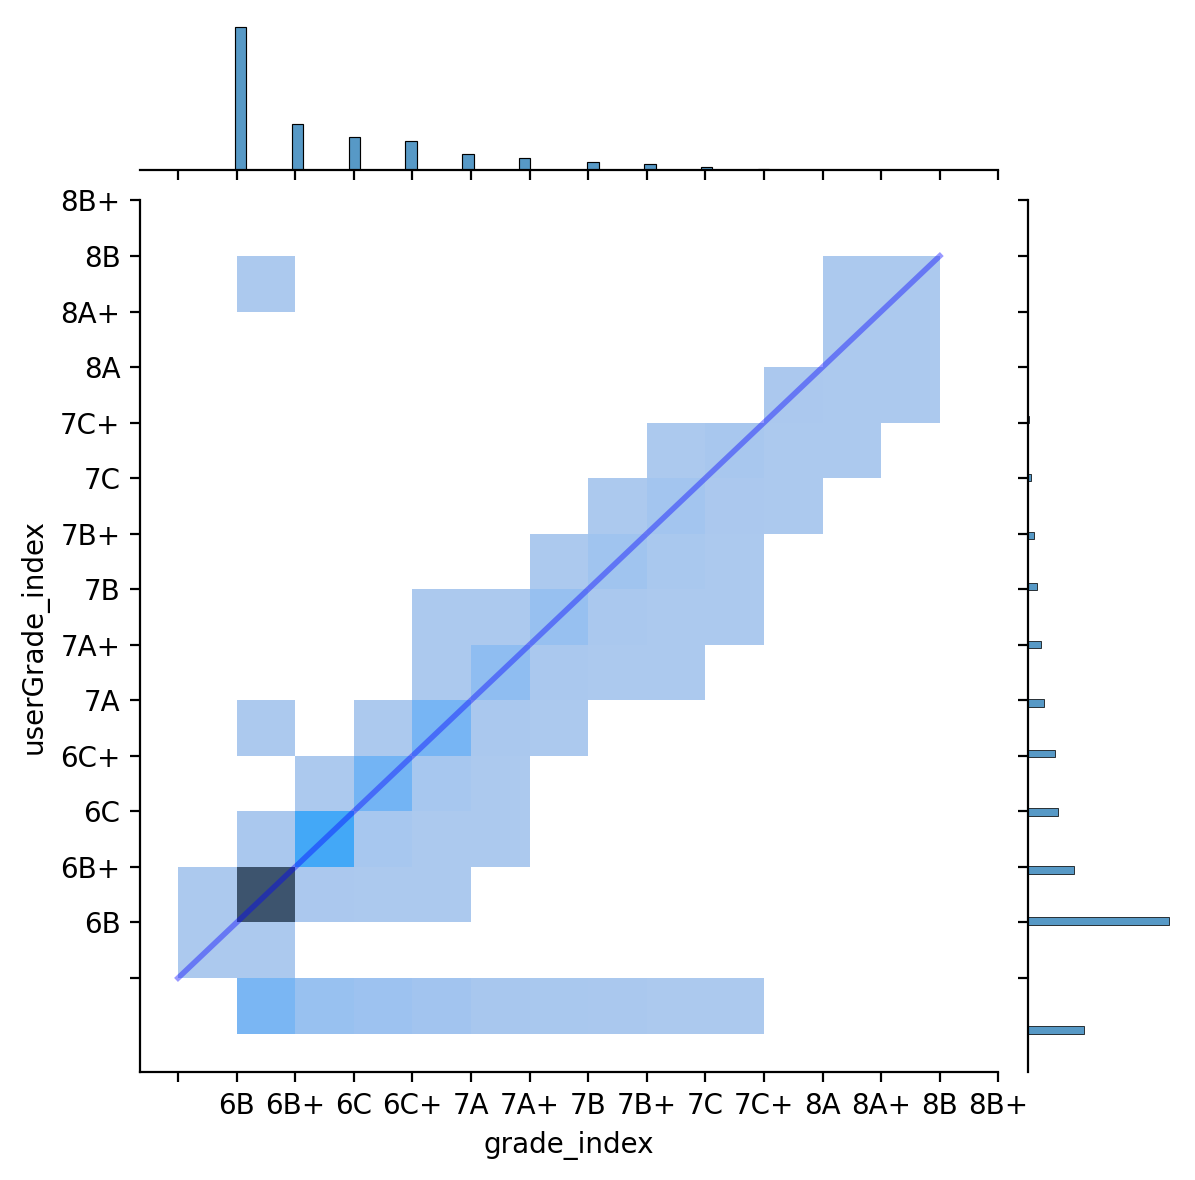

In [38]:
plot = sns.jointplot(
    data = df,
    x = 'grade_index',
    y = 'userGrade_index',
    kind = 'hist',
    binwidth = 1,
    # cmap = 'viridis'
)
plot.ax_joint.plot([0,13], [0, 13], 'b-', linewidth = 2, alpha = 0.4 )
plot.ax_joint.set_xticks( range( len( grades ) ), grades )
plot.ax_joint.set_yticks( range( len( grades ) ), grades )

plt.xlabel( 'Setter Grade' )
plt.ylabel( 'Voted Grade' )

In [39]:
grade, is_benchmark, moves, repeats = [], [], [], []
for i, row in df.iterrows():
    # row = row['data']
    grade.append(row['grade'])
    is_benchmark.append(row['isBenchmark'])
    moves.append( [ move['description'] for move in row['moves'] ] )
    repeats.append( row['repeats'] )

In [40]:
processed_df = pd.DataFrame( {
    'grade': grade,
    'is_benchmark': is_benchmark,
    'moves': moves,
    'repeats': repeats
} )

In [41]:
display( processed_df )

,grade,is_benchmark,moves,repeats
0,6B+,True,"[E6, C5, E8, F11, C13, D15, D18]",28038
1,6B+,True,"[F5, J8, I11, K11, G13, E15, E18]",40377
2,6B+,False,"[F5, J5, F9, C10, G13, E15, I18]",863
3,7A,True,"[B10, E6, E8, E12, E16, G4, I18, J5]",9514
4,7A,False,"[C5, D7, A9, F11, F13, I14, E16, D18]",275
...,...,...,...,...
28563,6C+,False,"[F5, J2, C6, H10, K8, G13, I14, K12, E15, G18,...",5
28564,6B+,False,"[G6, I6, H8, G4, E10, G13, E15, E18]",5
28565,6B+,False,"[F5, E10, H8, G13, H16, E16, D18]",11
28566,6B+,False,"[F5, G2, G9, C10, E12, A14, E16, B18]",5


In [42]:
holds = []

for i in range( 1, 150 ):
    try:
        hold = Image.open( 'holds/h' + str( i ) + '.png' )
        hold.load()
        holds.append( {
            'hold': hold,
            'i': i
        } )
    except:
        continue

In [43]:
import json

f = open( '2016holdset.txt' )
data = json.loads( f.read() )

locations = []

for holdset in data:
    for location in holdset['Holds']:
        locations.append( location['Location'] )

In [44]:
for location in locations:
    i = int( location['HoldNumber'] )
    
    for hold in holds:
        if hold['i'] == i:
            # print( 'Rotating hold', i, 'by', location['Rotation'] )
            hold['hold'] = hold['hold'].rotate( 360 - location['Rotation'] )

Text(0.5, 1.0, '1220')

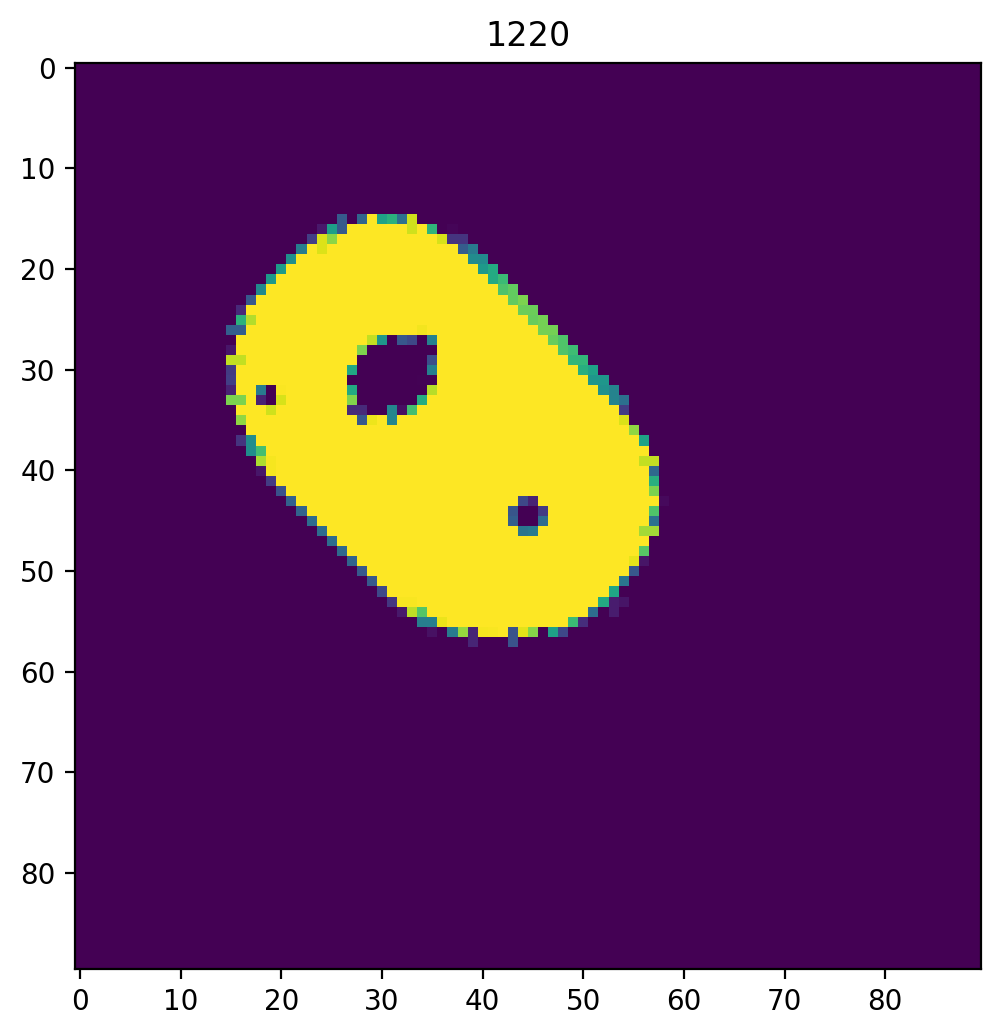

In [45]:
img = np.array( holds[-2]['hold'] )[:,:,3]
plt.imshow( img )
plt.title( len( np.nonzero( img )[0] ) )

In [46]:
# Calculate features about each hold

# Each hold has features:
# rotation: rotation of the hold

hold_features = {}

for location in locations:
    # features = [ ( location['Rotation'] % 180 ) / 180 ]
    features = []
    
    for hold in holds:
        if hold['i'] == int( location['HoldNumber'] ):
            # Calculate the area of the hold from its image
            img = np.array( hold['hold'] )[:,:,3] # Get the alpha channel
            size = len( np.nonzero( img )[0] ) # size is the number of non-zero pixels
            features.append( size )
            break
    
    hold_features[location['Description']] = features

In [47]:
def moves_to_features( moves ):
    print( moves, end = '\r' )
    features = np.zeros( ( 18, 11 ) )
    
    for move in moves:
        move = move.upper()
        if move not in hold_features.keys():
            continue
        features[int( move[1:] ) - 1, ord( str( move[0] ).upper() ) - 65 ] = 1
    return np.flip( features, axis = 0 )

In [48]:
import swifter

In [49]:
processed_df['features'] = processed_df.apply( 
    lambda x: moves_to_features( x['moves'] ), axis = 1
)

In [50]:
processed_df['features_flat'] = processed_df.apply( 
    lambda x: x['features'].flatten(), axis = 1
)

In [51]:
processed_df['grade_index'] = processed_df.apply(
    lambda x: grades[x['grade']], axis = 1
)

In [52]:
processed_df['n_holds'] = processed_df.apply(
    lambda x: len( x['moves'] ), axis = 1
)

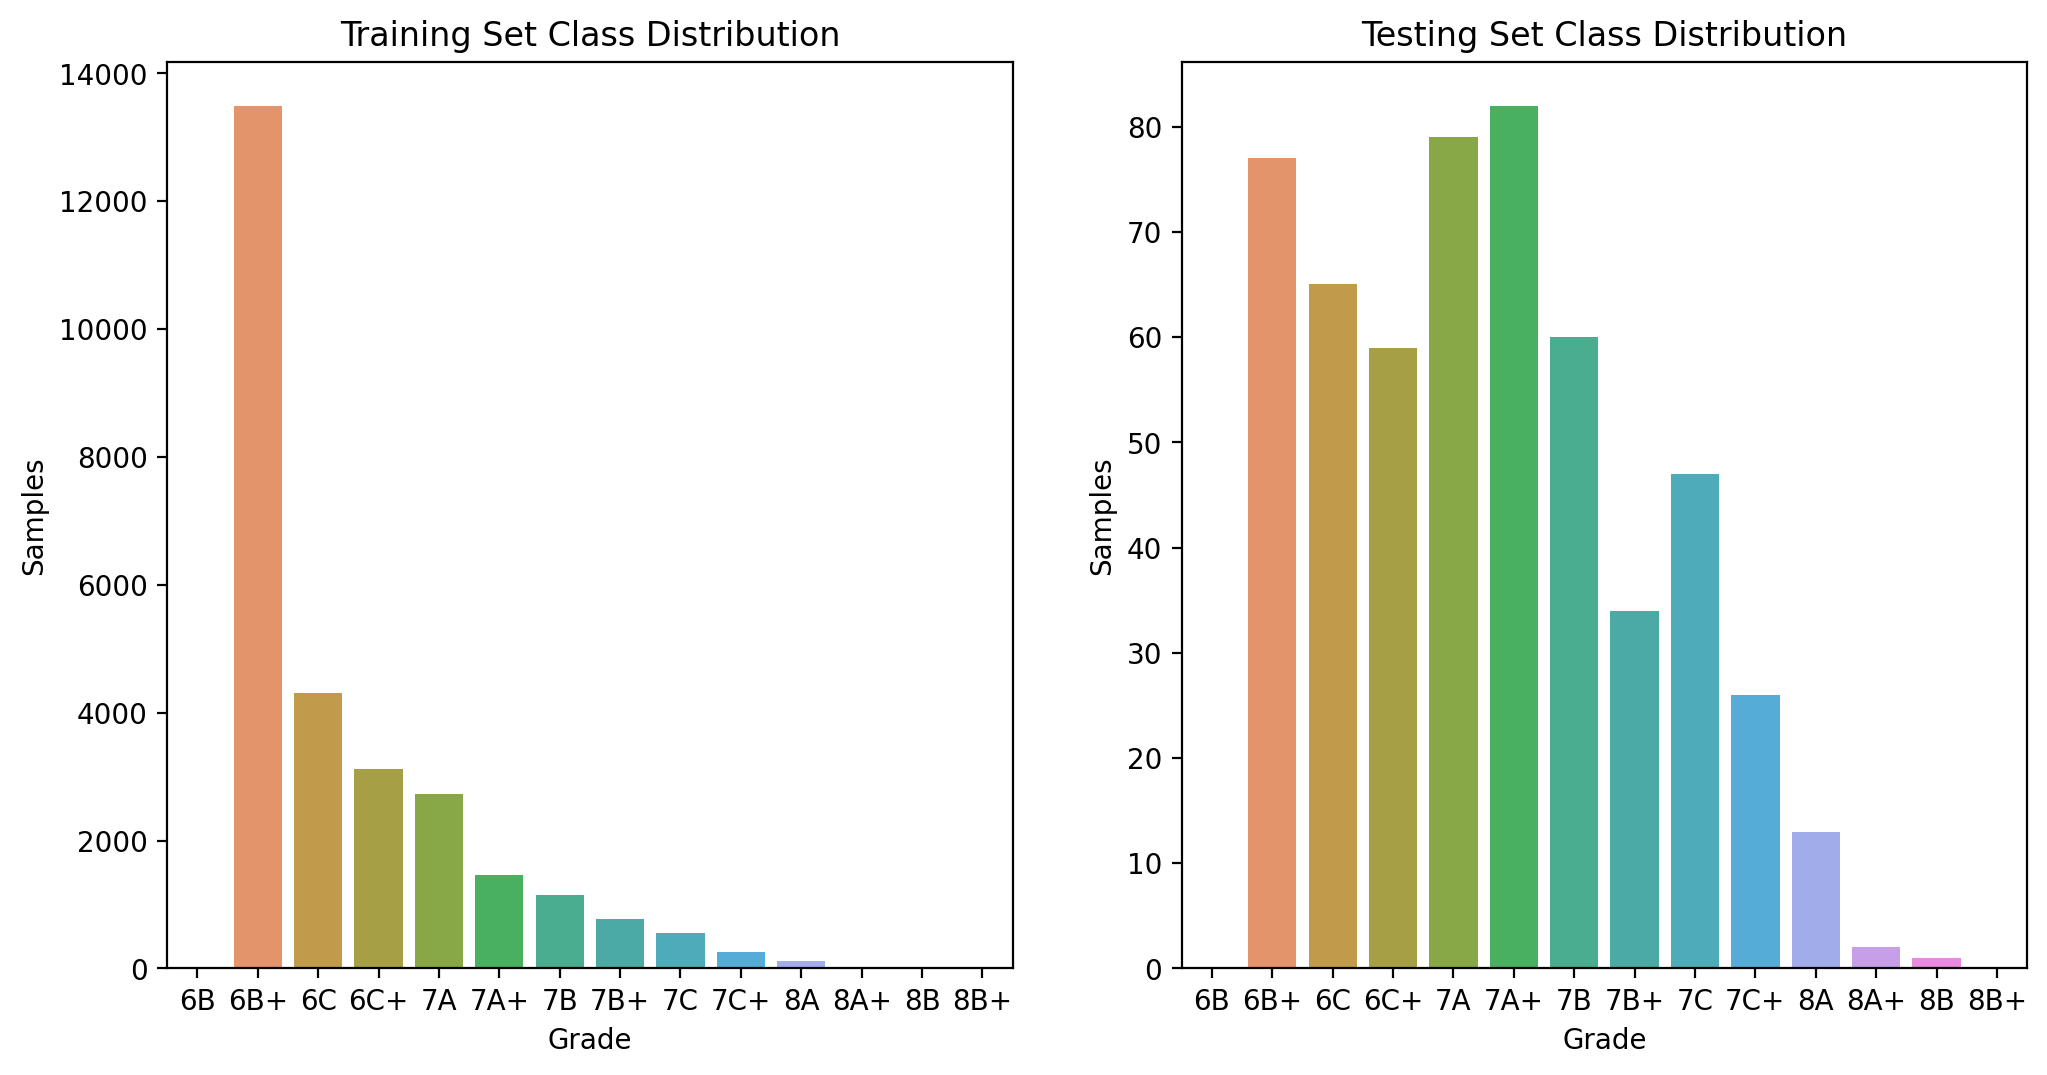

In [53]:
fig, ax = plt.subplots( ncols = 2 )

p = sns.countplot(
    ax = ax[0],
    data = processed_df[processed_df['is_benchmark'] == False],
    x = 'grade',
    order = np.sort( processed_df['grade'].unique() ),
)
p.set( title = 'Training Set Class Distribution' )
p.set( ylabel = 'Samples' )
p.set( xlabel = 'Grade' )

p = sns.countplot(
    ax = ax[1],
    data = processed_df[processed_df['is_benchmark'] == True],
    x = 'grade',
    order = np.sort( processed_df['grade'].unique() ),
)
p.set( title = 'Testing Set Class Distribution' )
p.set( ylabel = 'Samples' )
p.set( xlabel = 'Grade' )
plt.show()

plt.show()

In [54]:
display( processed_df )

,grade,is_benchmark,moves,repeats,features,features_flat,grade_index,n_holds
0,6B+,True,"[E6, C5, E8, F11, C13, D15, D18]",28038,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,7
1,6B+,True,"[F5, J8, I11, K11, G13, E15, E18]",40377,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1,7
2,6B+,False,"[F5, J5, F9, C10, G13, E15, I18]",863,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1,7
3,7A,True,"[B10, E6, E8, E12, E16, G4, I18, J5]",9514,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",4,8
4,7A,False,"[C5, D7, A9, F11, F13, I14, E16, D18]",275,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,8
...,...,...,...,...,...,...,...,...
28563,6C+,False,"[F5, J2, C6, H10, K8, G13, I14, K12, E15, G18,...",5,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...",3,11
28564,6B+,False,"[G6, I6, H8, G4, E10, G13, E15, E18]",5,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1,8
28565,6B+,False,"[F5, E10, H8, G13, H16, E16, D18]",11,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,7
28566,6B+,False,"[F5, G2, G9, C10, E12, A14, E16, B18]",5,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,8


In [55]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
import tensorflow as tf

In [56]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

def evaluate( train_predictions, predictions, y_train, y_test, plot_predictions = False ):
    metrics = {
        'train_mae': mae( y_train, train_predictions ),
        'train_rmse': mse( y_train, train_predictions ) ** ( 1 / 2 ),
        'test_mae': mae( y_test, predictions ),
        'test_rmse': mse( y_test, predictions ) ** ( 1 / 2 ),
    }
    
    predictions = predictions.flatten()
    
    if plot_predictions == True:
            # Residual plot
            plot = sns.jointplot(
                predictions,
                y_test,
                kind = 'hist',
            )
            plot.ax_joint.set_xticks( range( len( grades ) ), grades )
            plot.ax_joint.set_yticks( range( len( grades ) ), grades )
            plot.ax_joint.plot([0,13], [0, 13], 'b-', linewidth = 2, alpha = 0.4 )
            plot.ax_joint.set_xlabel( 'Predicted Grade' )
            plot.ax_joint.set_ylabel( 'True Grade' )

            plt.show()
            
            # Plot
    
    return metrics

In [57]:
X_train = np.array( processed_df[processed_df['is_benchmark'] == False]['features'].tolist() ).reshape( -1, 18 * 11 )
X_test = np.array( processed_df[processed_df['is_benchmark'] == True]['features'].tolist() ).reshape( -1, 18 * 11 )

y_train = np.array( processed_df[processed_df['is_benchmark'] == False]['grade_index'].tolist() )
y_test = np.array( processed_df[processed_df['is_benchmark'] == True]['grade_index'].tolist() )

In [58]:
len( y_train ), len( y_test ), len( processed_df )

(28023, 545, 28568)

In [59]:
train_repeats = np.array( processed_df[processed_df['is_benchmark'] == False]['repeats'].tolist() )

In [60]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes = np.unique( y_train ),
    y = y_train
)
class_weights = dict( enumerate( class_weights ) )

In [61]:
print( class_weights )

{0: 222.4047619047619, 1: 0.14832477637220134, 2: 0.4645260749925405, 3: 0.6413466379823317, 4: 0.7315946115288221, 5: 1.3700498679964799, 6: 1.7390467916097803, 7: 2.59280162842339, 8: 3.561642094560244, 9: 7.7283507997793714, 10: 18.03281853281853, 11: 100.08214285714286, 12: 500.4107142857143, 13: 153.97252747252747}


In [62]:
X = np.array( processed_df['features'].tolist() ).reshape( -1, 18 * 11 )
y = np.array( processed_df['grade_index'].tolist() )

In [63]:
import time
import datetime

In [64]:
def custom_loss_function( y_true, y_pred ):
    
    return 

In [73]:
dnn = Sequential( [
    layers.Input( shape = ( 18 * 11 ) ),
    layers.Dense( 64, activation = 'relu' ),
    layers.Dense( 32, activation = 'relu' ),
    layers.Dense( 16, activation = 'relu' ),
    layers.Dense( 1, activation = 'linear' ),
] )


cnn = Sequential( [
    layers.Input( shape = ( 18 * 11 ) ),
    layers.Reshape( target_shape = ( 18, 11, 1 ) ),
    layers.Conv2D( 32, 3, activation = 'relu' ),
    layers.BatchNormalization(),
    layers.Conv2D( 32, 3, activation = 'relu' ),
    layers.BatchNormalization(),
    layers.Conv2D( 64, 3, activation = 'relu' ),
    layers.BatchNormalization(),
    layers.Conv2D( 64, 3, activation = 'relu' ),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense( 32, activation = 'relu' ),
    layers.Dense( 1, activation = 'linear' ),
] )

lstm = Sequential( [
    layers.Input( shape = ( 18 * 11 ) ),
    layers.Reshape( target_shape = ( 18, 11 ) ),
    layers.LSTM( 128 ),
    layers.Dense( 32, activation = 'relu' ),
    layers.Dense( 1, activation = 'linear' ),
] )

nn = Sequential( [
    layers.Input( shape = ( 18 * 11 ) ),
    layers.Dense( 128, activation = 'relu', kernel_regularizer = regularizers.l2( 0.001 ) ),
    layers.Dropout( 0.1 ),
    layers.Dense( 128, activation = 'relu', kernel_regularizer = regularizers.l2( 0.001 ) ),
    layers.Dropout( 0.1 ),
    layers.Dense( 128, activation = 'relu', kernel_regularizer = regularizers.l2( 0.001 ) ),
    layers.Dropout( 0.1 ),
    layers.Dense( 128, activation = 'relu', kernel_regularizer = regularizers.l2( 0.001 ) ),
    layers.Dropout( 0.1 ),
    layers.Dense( 128, activation = 'relu', kernel_regularizer = regularizers.l2( 0.001 ) ),
    layers.Dropout( 0.1 ),
    layers.Dense( 128, activation = 'relu', kernel_regularizer = regularizers.l2( 0.001 ) ),
    layers.Dropout( 0.1 ),
    layers.Dense( 1, activation = 'linear' ),
] )

nn = Sequential( [
    layers.Input( shape = ( 18 * 11 ) ),
    layers.Reshape( target_shape = ( 18, 11, 1 ) ),
    layers.Conv2D( 32, 5, strides = 2, activation = 'relu', padding = 'same' ),
    layers.BatchNormalization(),
    layers.Conv2D( 32, 3, strides = 1, activation = 'relu', padding = 'same' ),
    layers.BatchNormalization(),
    layers.Conv2D( 64, 3, strides = 1, activation = 'relu', padding = 'same' ),
    layers.BatchNormalization(),
    layers.Conv2D( 64, 3, strides = 1, activation = 'relu', padding = 'same' ),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense( 32, activation = 'relu' ),
    layers.Dense( 1, activation = 'linear' ),
] )

models = [ dnn, cnn, lstm, nn ]
models = [ nn ]
for model in models:
    model.compile(
        loss = 'mean_squared_error',
        optimizer = 'adam',
        metrics = [
            tf.keras.metrics.RootMeanSquaredError( name = 'RMSE' ),
            tf.keras.metrics.MeanAbsoluteError( name = 'MAE' ),
        ]
    )

In [72]:
nn.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_27 (Reshape)        (None, 18, 11, 1)         0         
                                                                 
 conv2d_68 (Conv2D)          (None, 9, 6, 32)          832       
                                                                 
 batch_normalization_64 (Bat  (None, 9, 6, 32)         128       
 chNormalization)                                                
                                                                 
 conv2d_69 (Conv2D)          (None, 9, 6, 32)          9248      
                                                                 
 batch_normalization_65 (Bat  (None, 9, 6, 32)         128       
 chNormalization)                                                
                                                                 
 conv2d_70 (Conv2D)          (None, 9, 6, 64)        

In [74]:
model_names = [ 'DNN', '2DCNN', 'LSTM' ]
model_names = [ 'DNN' ]

scores = []

for model, model_name in zip( models, model_names ):
    print( model_name )
    start_time = time.time()
    history = model.fit( 
        X_train, 
        y_train,
        validation_data = ( X_test, y_test ),
        # sample_weight = np.log( train_repeats ) + 1,
        # class_weight = class_weights,
        epochs = 200,
        batch_size = 8,
        # verbose = 0,
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor = "val_loss",
                patience = 20,
                restore_best_weights = True,
                start_from_epoch = 10,
            )
        ]
    )
        
    for key in history.history.keys():
        plt.plot( history.history[key] )
    plt.legend( list( history.history.keys() ) )
    plt.title( 'Training Curve' )
    plt.xlabel( 'Epochs' )
    plt.ylabel( 'Loss' )
    plt.show()
    
    timestamp = time.time() - start_time
    print( 'Time to Fit:', timestamp )
    
    train_predictions = model.predict( X_train )
    predictions = model.predict( X_test )
    
    scores.append( evaluate( train_predictions, predictions, y_train, y_test, plot_predictions = True ) )
    print( scores[-1] )
    print()

DNN
Epoch 1/200


2023-10-31 20:25:33.404063: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:433] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-10-31 20:25:33.404116: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops_fused_impl.h:621 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Graph execution error:

Detected at node 'sequential_43/conv2d_80/Relu' defined at (most recent call last):
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/asyncio/base_events.py", line 595, in run_forever
      self._run_once()
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/asyncio/base_events.py", line 1881, in _run_once
      handle._run()
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
      result = self._run_cell(
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2900, in _run_cell
      return runner(coro)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3301, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3361, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_886467/3750595495.py", line 9, in <cell line: 6>
      history = model.fit(
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/engine/sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 314, in call
      return self.activation(outputs)
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/keras/backend.py", line 5369, in relu
      x = tf.nn.relu(x)
Node: 'sequential_43/conv2d_80/Relu'
DNN library is not found.
	 [[{{node sequential_43/conv2d_80/Relu}}]] [Op:__inference_train_function_18252]

In [58]:
scores = scores.drop( columns = 'Model Name' )

AttributeError: 'list' object has no attribute 'drop'

In [66]:
scores = pd.DataFrame( scores )
scores['names'] = model_names

names = {
    'train_mae': 'Training MAE',
    'train_rmse': 'Training RMSE',
    'test_mae': 'Testing MAE',
    'test_rmse': 'Testing RMSE',
    'names': 'Model Name',
}

scores = scores.rename( columns = names )

display( scores )

,Training MAE,Training RMSE,Testing MAE,Testing RMSE,Model Name
0,0.464537,0.68597,0.877134,1.128256,DNN


[]

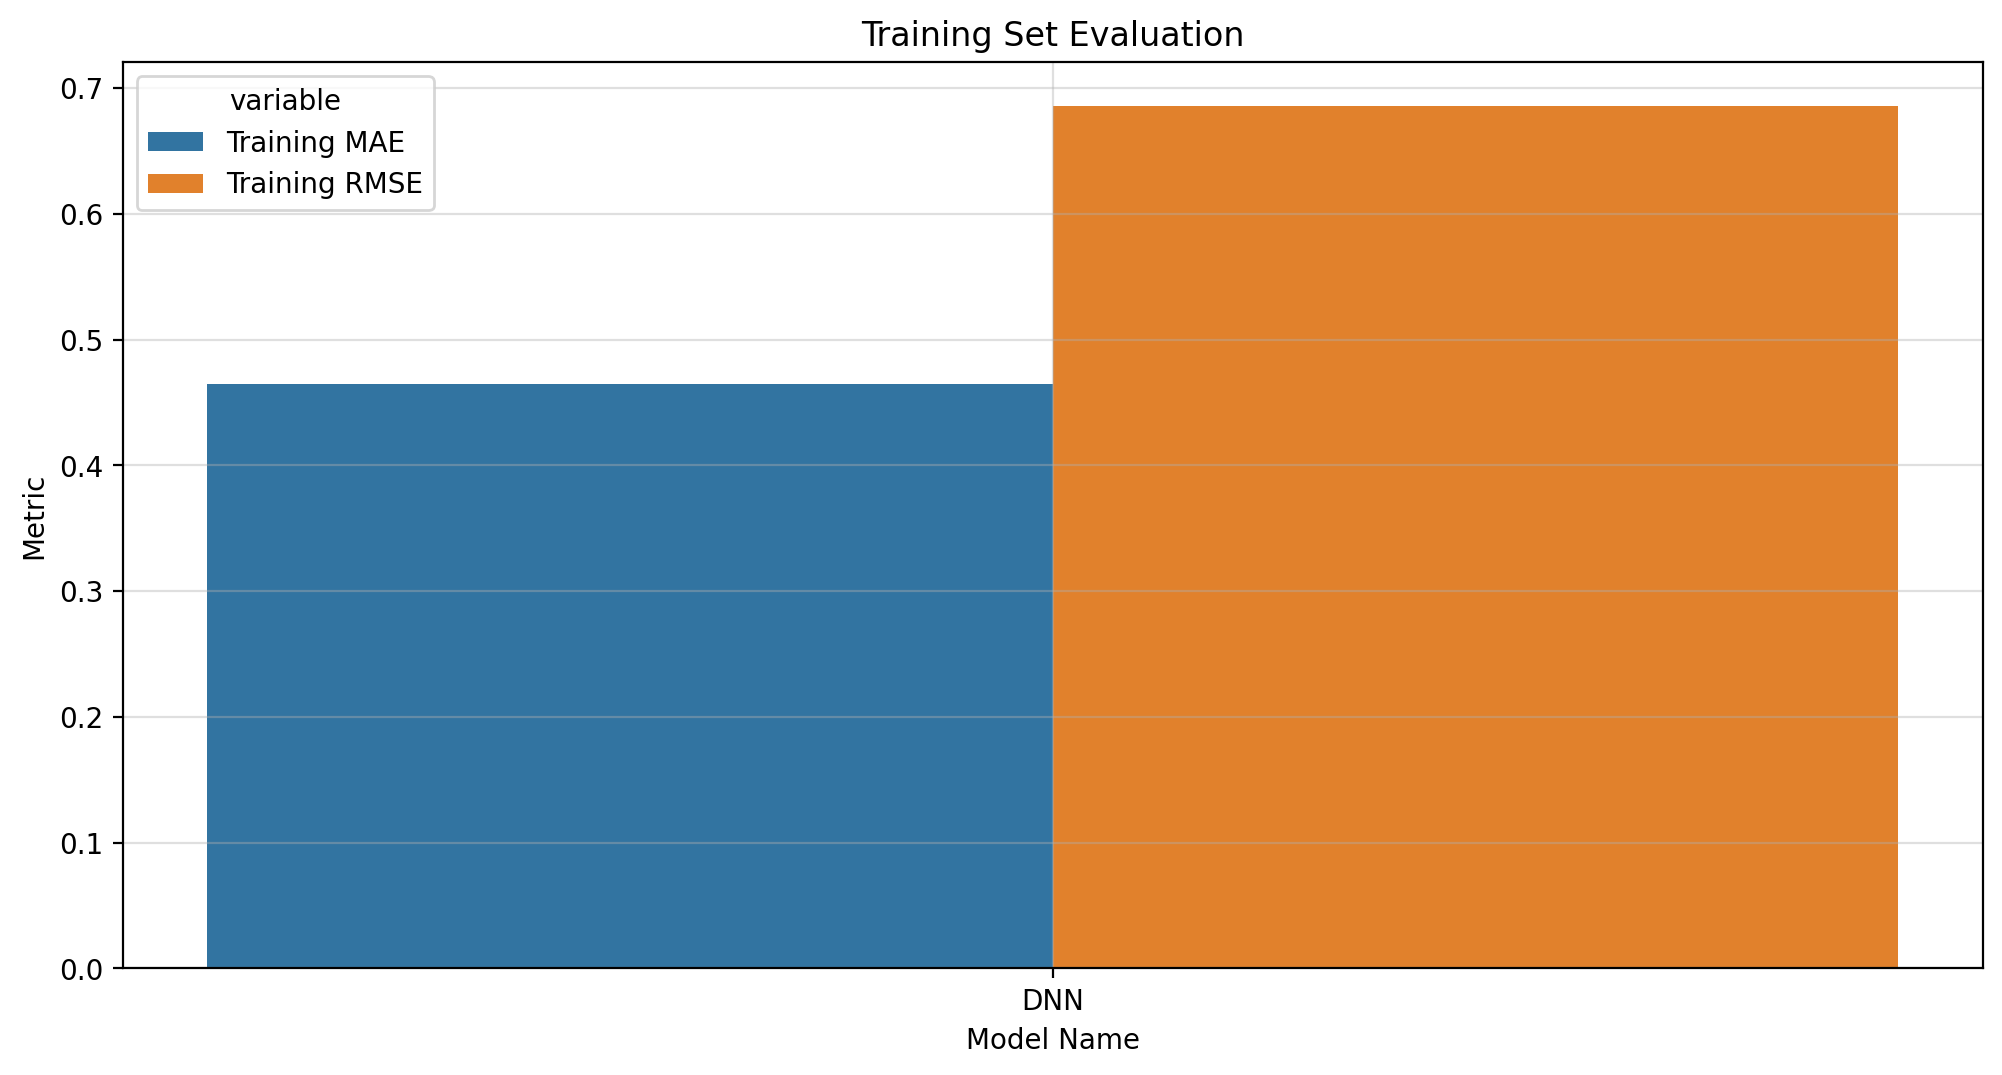

In [67]:
plot = sns.barplot(
    data = pd.melt( scores, id_vars = 'Model Name', value_vars = [ 'Training MAE', 'Training RMSE' ] ),
    y = 'value',
    x = 'Model Name',
    hue = 'variable',
    palette = 'tab10'
)
plot.set_title( 'Training Set Evaluation' )
plt.ylabel( 'Metric' )
plt.grid( alpha = 0.4 )
plt.plot()

[]

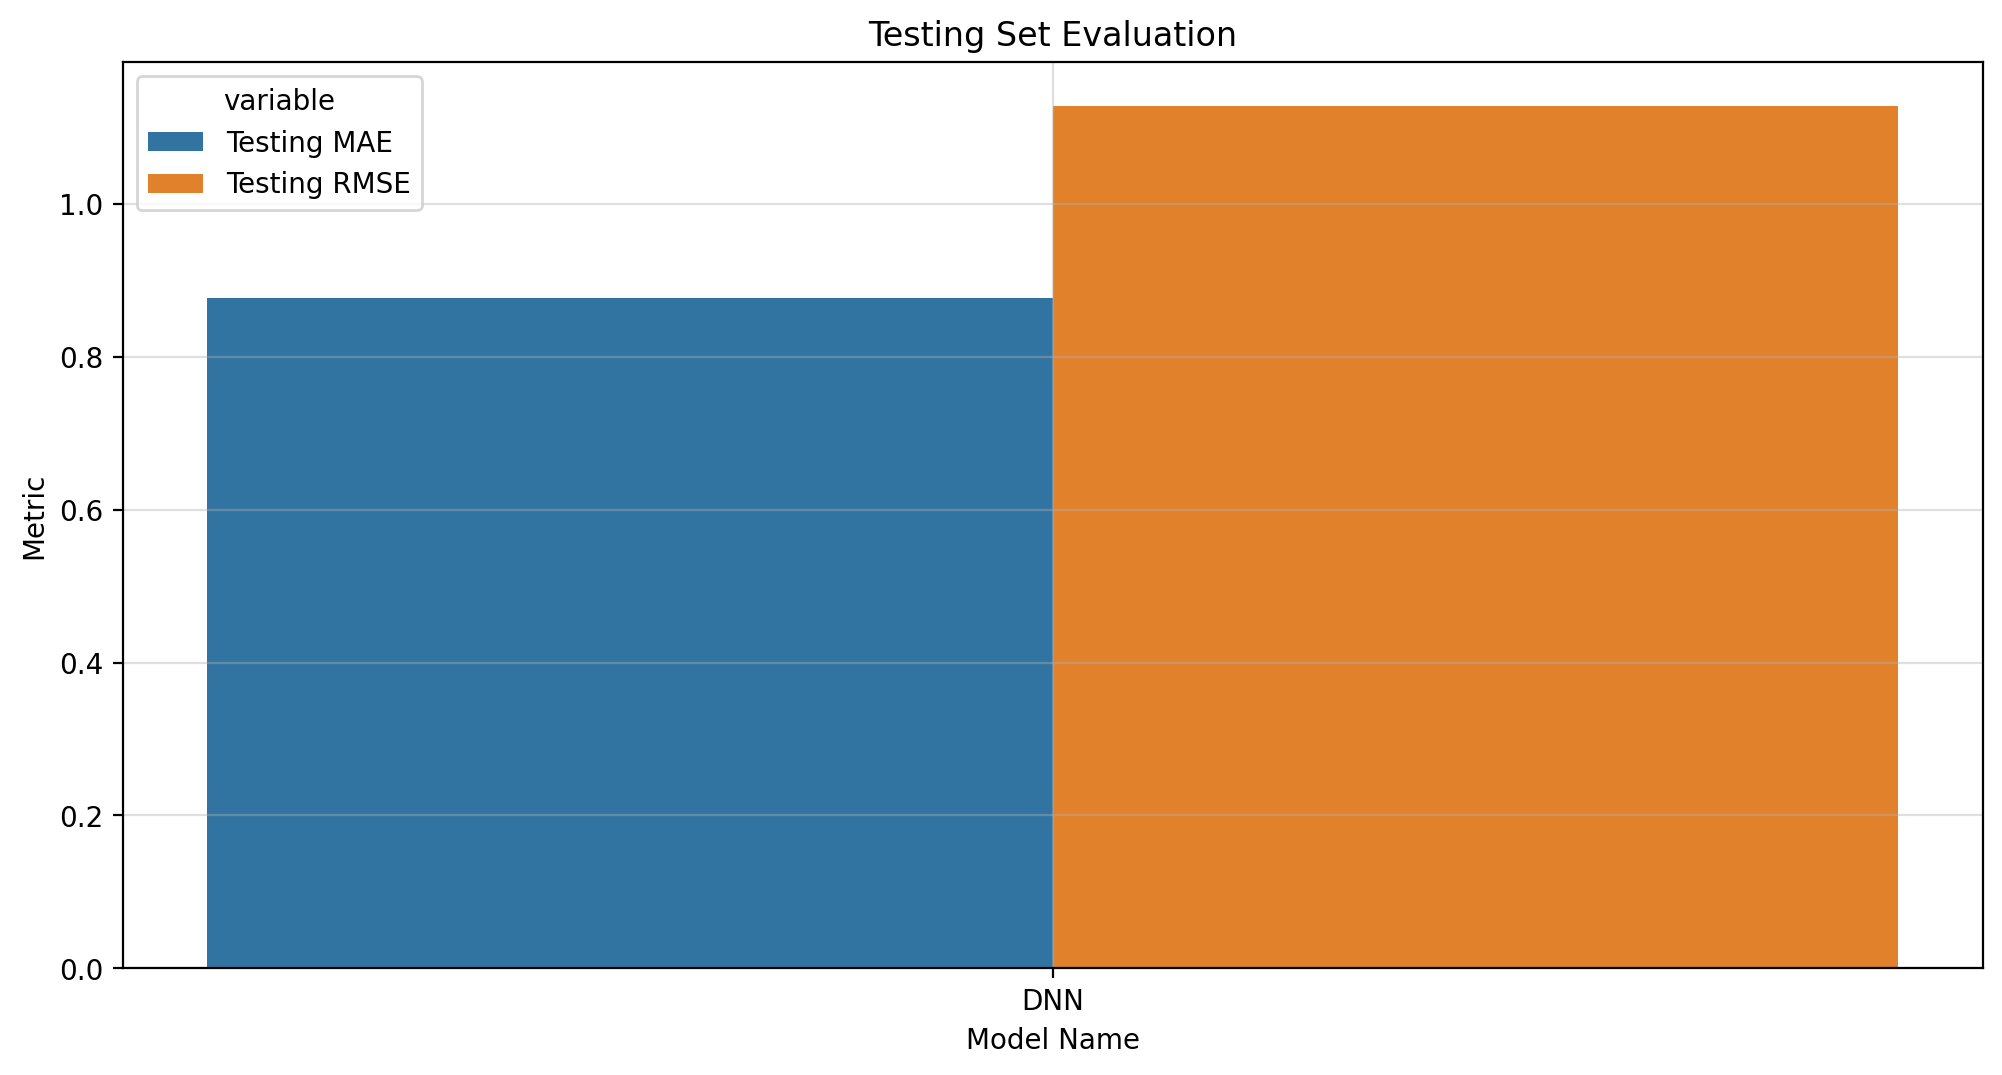

In [68]:
plot = sns.barplot(
    data = pd.melt( scores, id_vars = 'Model Name', value_vars = [ 'Testing MAE', 'Testing RMSE' ] ),
    y = 'value',
    x = 'Model Name',
    hue = 'variable',
    palette = 'tab10'
)
plot.set_title( 'Testing Set Evaluation' )
plt.ylabel( 'Metric' )
plt.grid( alpha = 0.4 )
plt.plot()

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [71]:
predictions = models[0].predict( X_test )

18/18 [==============================] - 0s 4ms/step


In [72]:
predictions = np.round( predictions ).flatten()

In [73]:
predictions = np.round( predictions )

print( classification_report( y_test, predictions, labels = range( 14 ), target_names = [ key for key in grades.keys() ][1:] ) )

              precision    recall  f1-score   support

          6B       0.00      0.00      0.00         0
         6B+       0.75      0.58      0.66        77
          6C       0.37      0.48      0.42        65
         6C+       0.31      0.37      0.34        59
          7A       0.38      0.34      0.36        79
         7A+       0.35      0.27      0.31        82
          7B       0.33      0.35      0.34        60
         7B+       0.22      0.38      0.28        34
          7C       0.31      0.23      0.27        47
         7C+       0.17      0.12      0.14        26
          8A       0.25      0.23      0.24        13
         8A+       0.33      1.00      0.50         2
          8B       0.00      0.00      0.00         1
         8B+       0.00      0.00      0.00         0

   micro avg       0.37      0.37      0.37       545
   macro avg       0.27      0.31      0.27       545
weighted avg       0.38      0.37      0.37       545



/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/ho

Text(0.5, 1.0, 'Error vs Number of Holds')

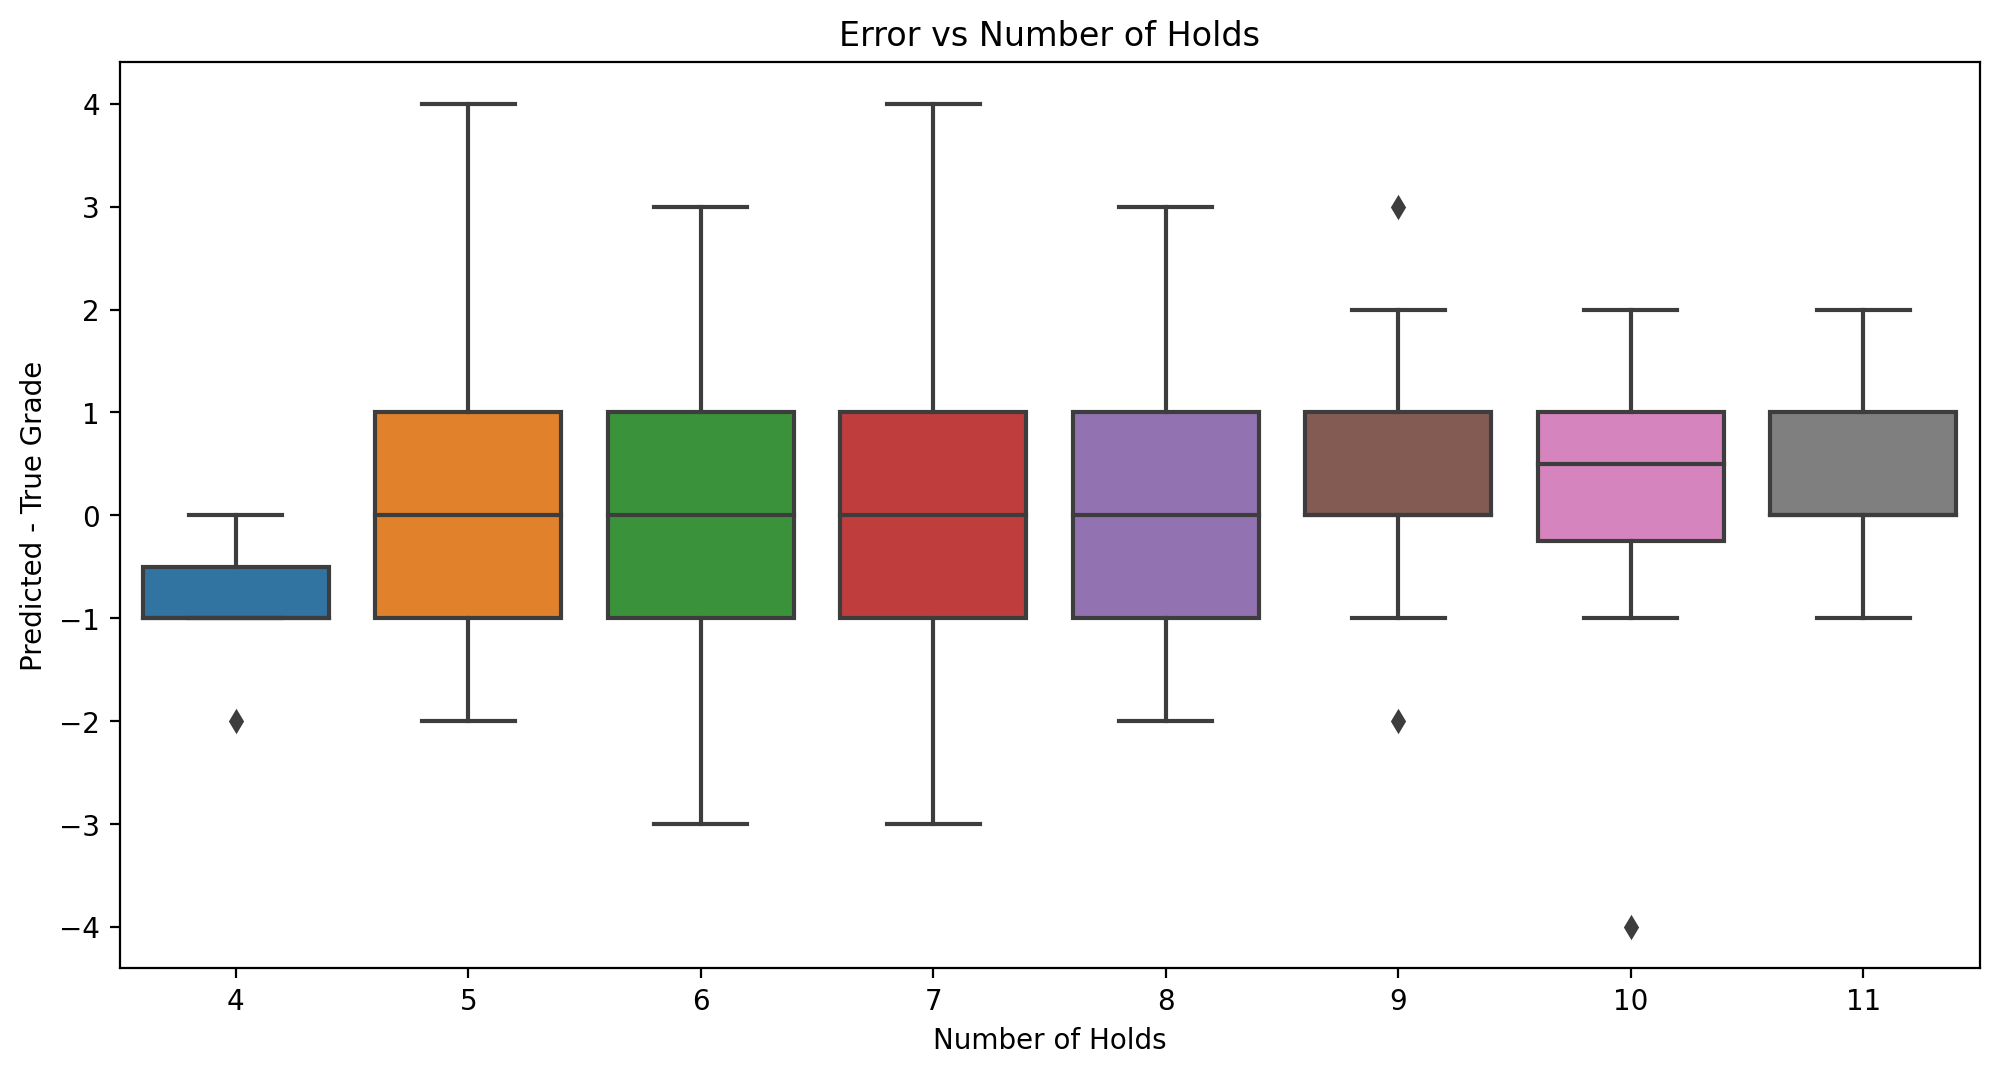

In [74]:
plot = sns.boxplot(
    np.sum( X_test > 0, axis = 1 ),
    ( predictions - y_test ),
)
plt.xlabel( 'Number of Holds' )
plt.ylabel( 'Predicted - True Grade' )
plt.title( 'Error vs Number of Holds' )

In [73]:
plot = sns.boxplot(
    np.sum( X_test > 0, axis = 1 ),
    np.abs( y_test - lr.predict( transform.transform( X_test ) ) ),
)
plt.xlabel( 'Number of Holds' )
plt.ylabel( 'Grade Error' )

NameError: name 'lr' is not defined

ValueError: The number of FixedLocator locations (12), usually from a call to set_ticks, does not match the number of ticklabels (15).

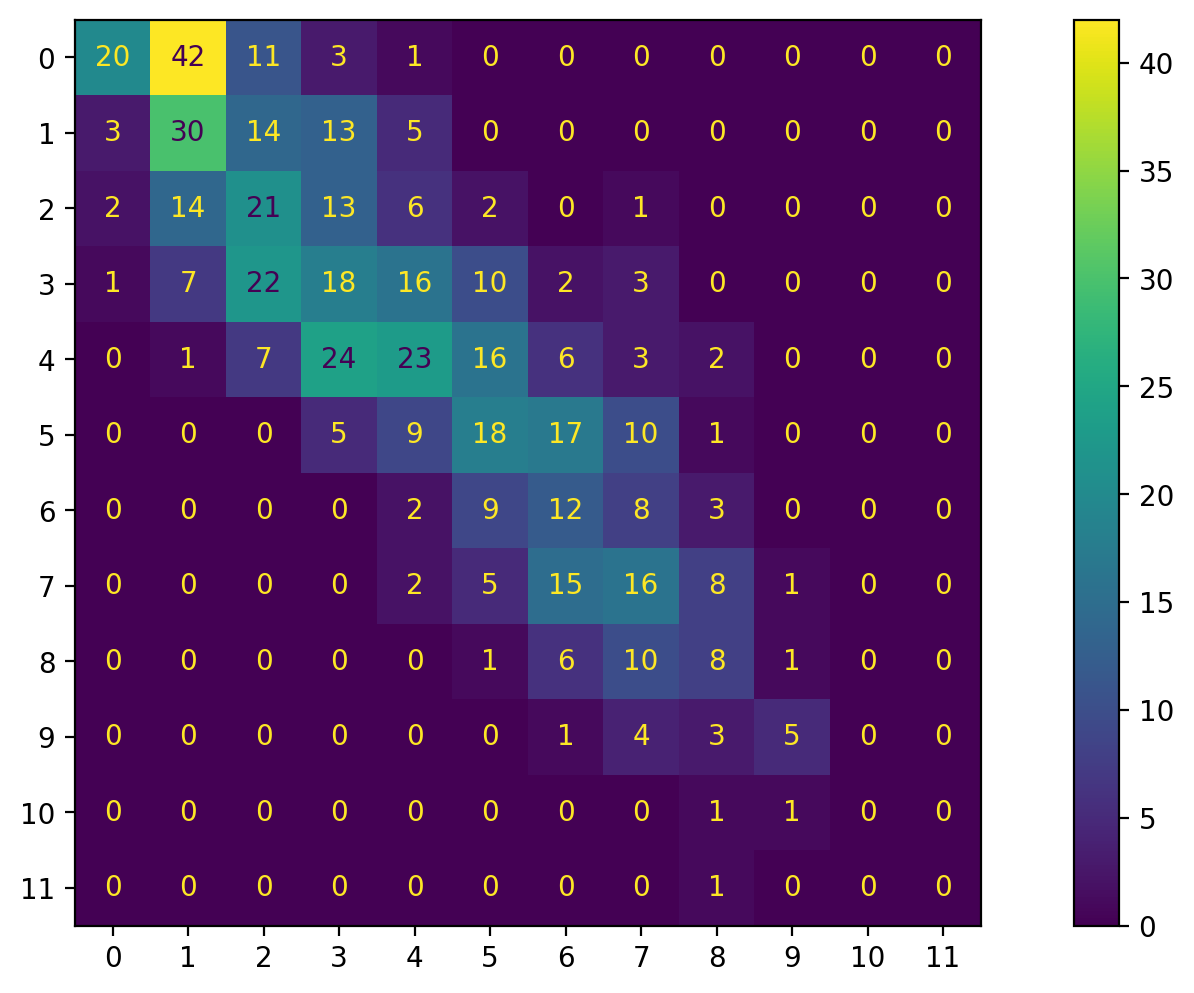

In [99]:
cm = confusion_matrix( y_test, predictions )
disp = ConfusionMatrixDisplay( confusion_matrix = cm, display_labels = grades )
disp.plot()
plt.show()

In [101]:
print( lr.coef_.shape )
print( transform.components_.shape )

(140,)
(140, 198)


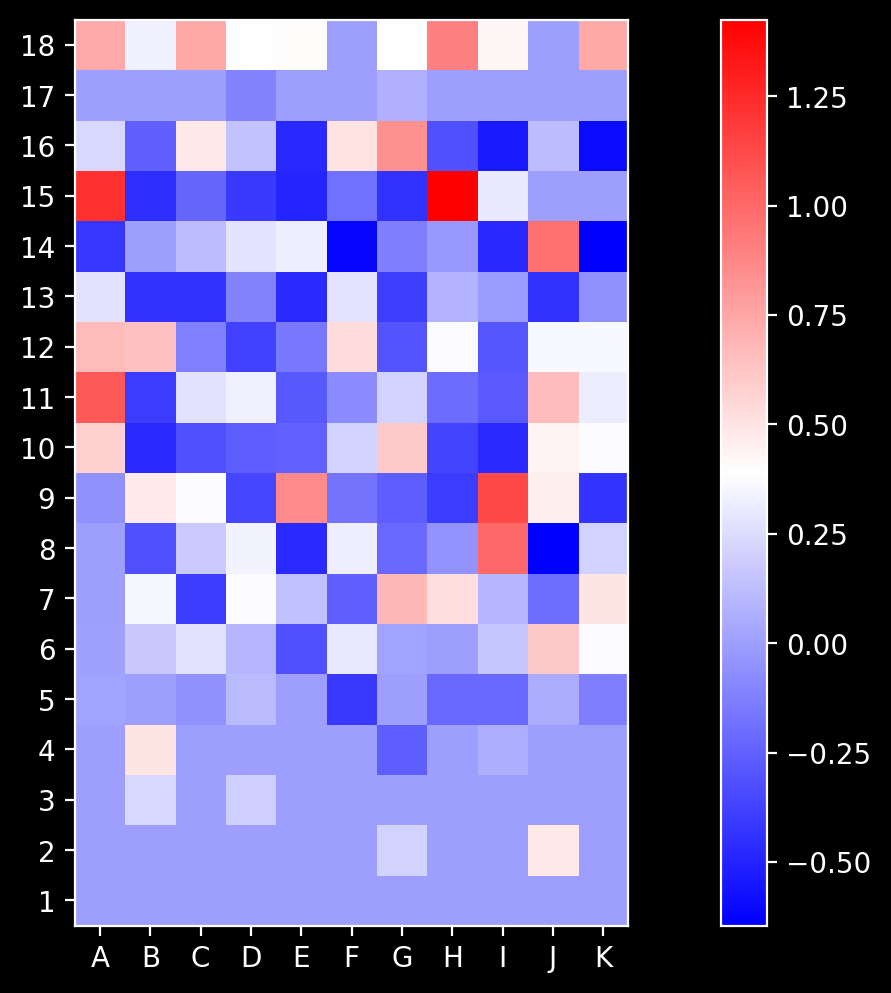

In [103]:
plt.imshow( ( np.dot(lr.coef_, transform.components_) + transform.mean_ ).reshape( 18, 11 ), cmap = 'bwr' )
plt.colorbar()
plt.yticks( range( 18 ), range( 18, 0, -1 )  )
plt.xticks( range( 11 ), [ c.upper() for c in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', ] ] )
plt.show()

In [ ]:
from matplotlib.colors import LogNorm

sns.heatmap( 
    np.cov( X.T ),
    norm = LogNorm(),
)

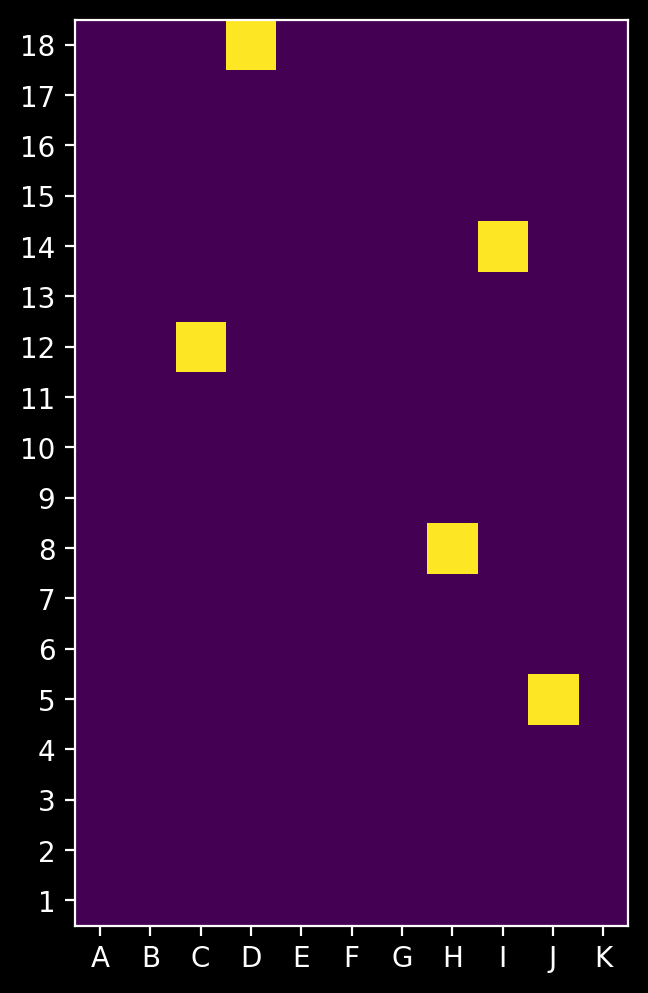

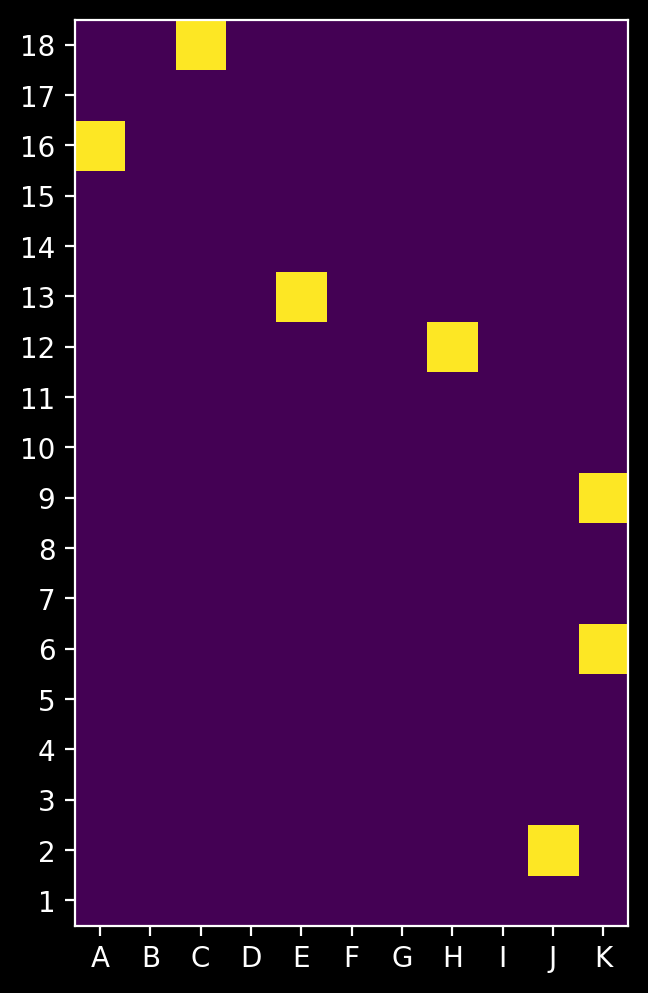

In [117]:
for climb in X_test[np.abs( y_test - predictions ) > 4]:
    plt.imshow( climb.reshape( 18, 11 ) )
    plt.yticks( range( 18 ), range( 18, 0, -1 )  )
    plt.xticks( range( 11 ), [ c.upper() for c in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', ] ] )
    plt.show()

In [100]:
# Add some engineered features:
# Number of holds
# Average distance between holds